In [1]:
import numpy as np
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import forAustin as fa

In [2]:
fits = pf.open('/media/data/austinfortino/austinFull.fits')
fits.info()
nExposure = 432
exposure = fa.getExposure(fits, nExposure, polyOrder=3)

Filename: /media/data/austinfortino/austinFull.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  Exposures     1 BinTableHDU     47   2820R x 19C   [1D, 1D, 4A, 1D, 8A, 1D, 1J, 1J, 1D, 1D, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  2  RESIDUALS     1 BinTableHDU     25   73818788R x 8C   [I, J, D, D, D, D, D, L]   


In [3]:
ind = np.where(exposure['hasGaia'])[0]
u = np.take(exposure['u'], ind)
v = np.take(exposure['v'], ind)
dx = np.take(exposure['dx'], ind)
dy = np.take(exposure['dy'], ind)
err = np.take(exposure['measErr'], ind)

In [4]:
class GP(object):
    
    def __init__(self, X, Y, err):
        self.X = X
        self.Y = Y
        self.err = err
        
    def RBF(self, x1, x2, l, var_s):
        """The kernel function."""
        dx2 = (x1-x2)**2
        return var_s * np.exp(-dx2 / (2 * l))
        
    def split_data(self, test_size, random_state):
        """Separate data into training and testing sets with sklearn."""
        self.Xtrain, self.Xtest, self.Ytrain, self.Ytest, self.Etrain, self.Etest = \
            train_test_split(self.X, self.Y, self.err, test_size=test_size, random_state=random_state)

    def gen_RBF_Covariance(self, l, var_s):
        """Generate relevant covariance matrices."""
        x1, x2 = np.meshgrid(self.Xtrain, self.Xtrain)
        self.K = self.RBF(x1, x2, l, var_s)
        x1, x2 = np.meshgrid(self.Xtest, self.Xtest)
        self.Kss = self.RBF(x1, x2, l, var_s)
        x1, x2 = np.meshgrid(self.Xtest, self.Xtrain)
        self.Ks = self.RBF(x1, x2, l, var_s)
    
    def gen_White_Covariance(self):
        """Generate white noise covariance matrix."""
        self.W = np.diag(self.Etrain)
        self.Ws = np.diag(self.Etest)
        
    def fit(self, l, var_s, test_size=0.2, random_state=1):
        """Calculate posterior distribution mean and covariance matrix, and standard deviations at each point."""
        # See Rasmussen and Williams 2006 Eq. 2.25 and 2.26.
        # eps = 1.49e-08
        
        self.split_data(test_size=test_size, random_state=random_state)
        self.gen_RBF_Covariance(l=l, var_s=var_s)
        self.gen_White_Covariance()
        
        KW_inv = np.linalg.inv(self.K + self.W)
        
        self.fbar_s = (self.Ks.T).dot(KW_inv).dot(self.Ytrain)
        self.V_s = self.Kss - (self.Ks.T).dot(KW_inv).dot(self.Ks)
        self.sigma = np.sqrt(np.abs(np.diag(self.V_s)))
    
    def draw(shape=1):
        """Draw from the posterior distribution."""
        return np.random.multivariate_normal(self.fbar_s, self.V_s, size=size).T
    
    def plot(self):
        plt.figure(figsize=(14, 7))
        plt.scatter(self.Xtrain, self.Ytrain, alpha=0.5, label='Training Data')
        plt.scatter(self.Xtest, self.Ytest, alpha=0.5, label='Testing Data')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(14, 7))
        plt.errorbar(
            self.Xtest,
            self.fbar_s,
            xerr=None,
            yerr=self.sigma,
            fmt='o',
            label=r'Posterior Predictive Mean w/ 1$\sigma$',
            color='gray')
        plt.legend()
        plt.show()

In [5]:
uGP = GP(u, dx, err)
uGP.fit(l=1, var_s=1)

In [6]:
vGP = GP(v, dy, err)
vGP.fit(l=1, var_s=1)

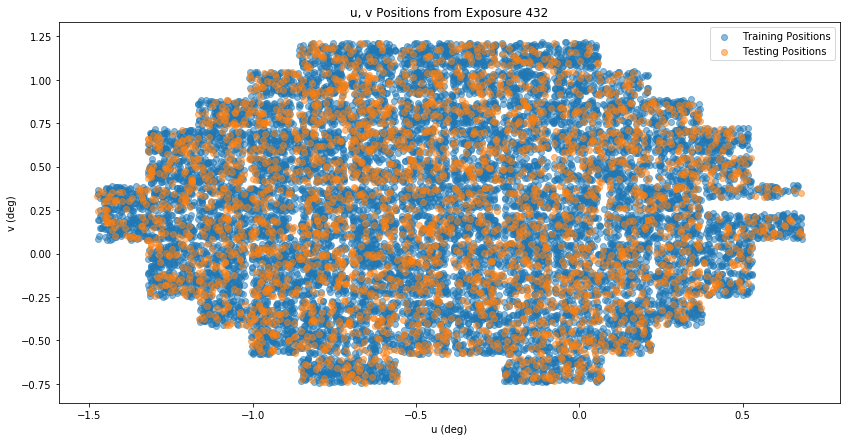

In [7]:
plt.figure(figsize=(14, 7))
plt.title(f"u, v Positions from Exposure {nExposure}")
plt.xlabel("u (deg)")
plt.ylabel("v (deg)")
plt.scatter(uGP.Xtrain, vGP.Xtrain, alpha=0.5, label="Training Positions")
plt.scatter(uGP.Xtest, vGP.Xtest, alpha=0.5, label="Testing Positions")
plt.legend()
plt.savefig("uvPositions.pdf")
plt.show()

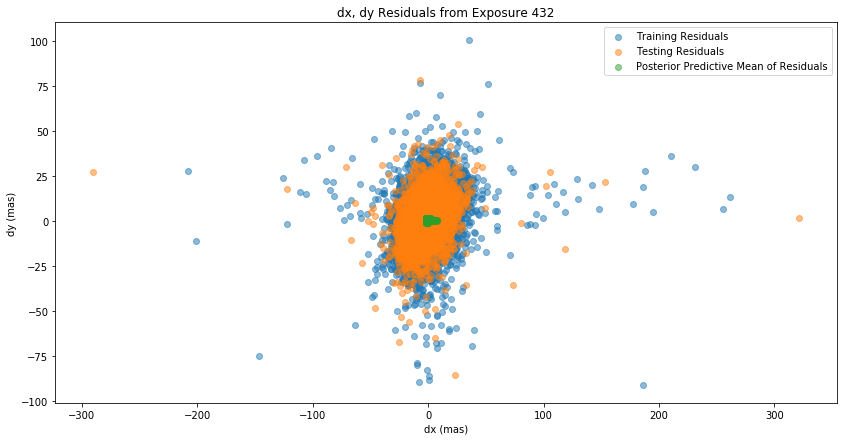

In [8]:
plt.figure(figsize=(14, 7))
plt.title(f"dx, dy Residuals from Exposure {nExposure}")
plt.xlabel("dx (mas)")
plt.ylabel("dy (mas)")
plt.scatter(uGP.Ytrain, vGP.Ytrain, alpha=0.5, label="Training Residuals")
plt.scatter(uGP.Ytest, vGP.Ytest, alpha=0.5, label="Testing Residuals")
plt.scatter(uGP.fbar_s, vGP.fbar_s, alpha=0.5, label="Posterior Predictive Mean of Residuals")
plt.legend()
plt.savefig("Residuals.pdf")
plt.show()

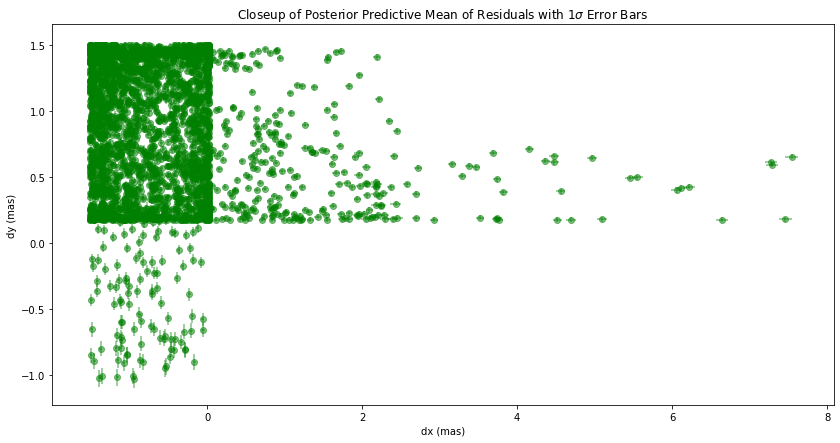

In [9]:
plt.figure(figsize=(14, 7))
plt.title("Closeup of Posterior Predictive Mean of Residuals with 1$\sigma$ Error Bars")
plt.xlabel("dx (mas)")
plt.ylabel("dy (mas)")
plt.errorbar(
    uGP.fbar_s,
    vGP.fbar_s,
    xerr=uGP.sigma,
    yerr=vGP.sigma,
    fmt='o',
    color='green',
    alpha=0.5)
plt.savefig("Closeup.pdf")
plt.show()

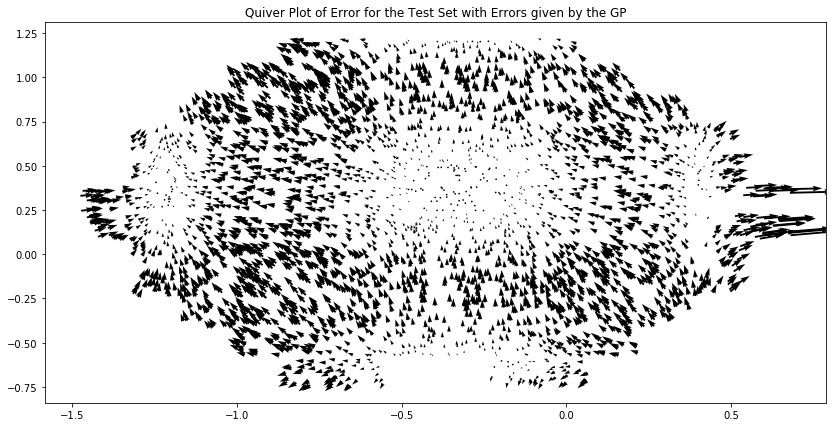

In [10]:
plt.figure(figsize=(14, 7))
plt.title("Quiver Plot of Error for the Test Set with Errors given by the GP")
plt.quiver(uGP.Xtest, vGP.Xtest, uGP.fbar_s, vGP.fbar_s)
plt.savefig("Quiver_GP.pdf")
plt.show()

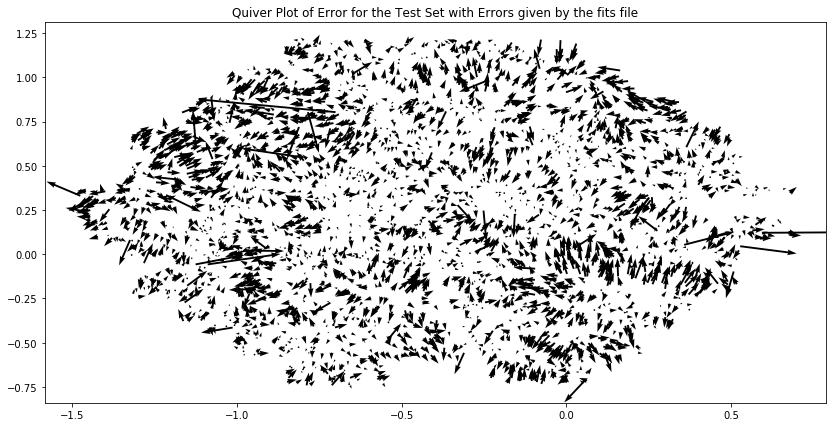

In [11]:
plt.figure(figsize=(14, 7))
plt.title("Quiver Plot of Error for the Test Set with Errors given by the fits file")
plt.quiver(uGP.Xtest, vGP.Xtest, uGP.Ytest, vGP.Ytest)
plt.savefig("Quiver_data.pdf")
plt.show()

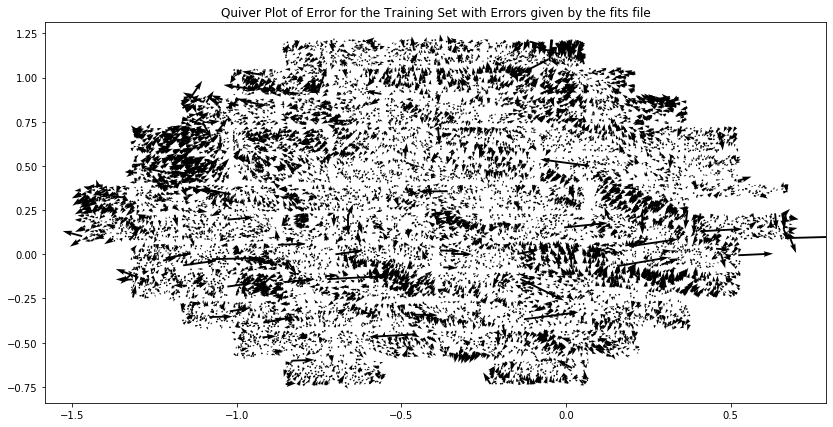

In [12]:
plt.figure(figsize=(14, 7))
plt.title("Quiver Plot of Error for the Training Set with Errors given by the fits file")
plt.quiver(uGP.Xtrain, vGP.Xtrain, uGP.Ytrain, vGP.Ytrain)

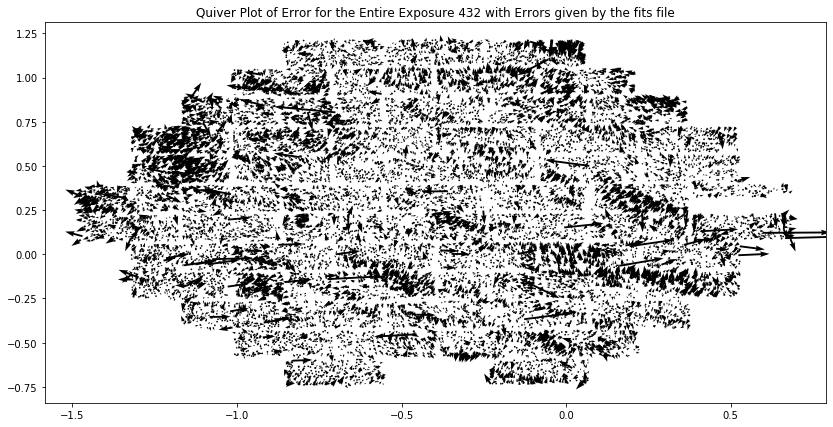

In [13]:
plt.figure(figsize=(14, 7))
plt.title(f"Quiver Plot of Error for the Entire Exposure {nExposure} with Errors given by the fits file")
plt.quiver(u, v, dx, dy)